## DERNA/EDANN
## Diseño Evolutivo de Redes Neuronales Artificiales
## Evolutionary Design of Artificial Neural Networks
Basado en el paper [Predicting Daily Returns of Global Stocks Indices: Neural Networks vs Support Vector Machines. Kaur, Dharni 2019](https://journaljemt.com/index.php/JEMT/article/view/30179)

Este programa reproduce los resultados del paper en ANN para el DJI usando datos obtenidos de Yahoo Finance. Se calcularon los indicadores técnicos según las fórmulas del paper y las indicaciones del autor.

Se usan los datos del DJI desde 20050401 hasta 20170331.
En el artículo, el autor logra una pérdida de 0.001-0.013 (media de 0.004), este logra 0.0018

baseline_kaur

V 1.0 20200505

V 2.0 20210520 Traducción de comentarios y correcciones de estilo. Se eliminaron las trazas de depuración.

V 3.0 20210530 Adaptación/Modularización para DERNA

Based on the paper [Predicting Daily Returns of Global Stocks Indices: Neural Networks vs Support Vector Machines. Kaur, Dharni 2019](https://journaljemt.com/index.php/JEMT/article/view/30179)

This programs reproduces the paper results on ANN for DJI using data from Yahoo Finance. The technical indicators were calculated based on the paper formulas and the author advise.

This program uses DJI data from 20050401 until 20170331.
In the paper the author achieves a loss of 0.001-0.013 (mean of 0.004), this one achieves 0.0018

baseline_kaur

V 1.0 20200505

V 2.0 20210520 Tranlation of comments and style corrections. Debug traces eliminated.

V 3.0 20210530 Adaptation/Modularization for EDANN

### Configuración
### Setup

#### Importar librerías y funciones
#### Import libraries and functions

In [9]:
!pip install -U tensorflow-addons
import numpy as np
import sklearn.preprocessing as skp
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt

Requirement already up-to-date: tensorflow-addons in /usr/local/lib/python3.7/dist-packages (0.13.0)


#### Hiperparámetros
#### Hyperparameters

In [10]:
p = {
     "scaler": skp.MinMaxScaler(feature_range=(-1,1)),
     "test_split": 0.20,  # 20% para prueba/20% of samples for test data
     "val_split": 0.20,  # 20% para validación/20% for validation
     "neurons": 9,
     "activation": "sigmoid",  # para la capa oculta/for the hidden layer
     "output_activation": "linear",  # capa de salida/for the output layer
     "optimizer": tf.keras.optimizers.SGD(
         learning_rate=0.3,
         momentum=0.2,
         nesterov=False),
     "loss": "mse",  # podría ser mae o mse/could be mae or mse
     "epochs": 500,  # épocas de entrenamiento/training epochs
     "batch_size": 100,
     "shuffle": False,  # los datos de entrenamiento/the training data
     "verbose": 0,  # verbosidad del entrenamiento/verbose training
     "seconds": 50,
    }

#### Carga de datos
#### Load data

In [11]:
path_to_downloaded_file = tf.keras.utils.get_file(
    "baseline_kaur.csv",
    "https://raw.githubusercontent.com/" +
    "jmacostap/webstore/master/baseline_kaur.csv",
    cache_dir="/content",
    )
data = np.loadtxt(path_to_downloaded_file, skiprows=1, delimiter=",")
print(f"{data.shape} samples read")

# extraer objetivos/extract targets
targets = np.reshape(data[:, -1], (-1, 1))
print(f"Targets to be used: {targets.shape}")

# extraer datos/extract features
data = data[:, :-1]
print(f"Samples to be used: {data.shape}")

# reservar datos de prueba/reserve test data
test_index = np.int(len(data)*p["test_split"])
print(f"Test fraction: {test_index}")
train_targets = targets[:-test_index]
print(f"Train targets: {train_targets.shape}")
train_data = data[:-test_index]
print(f"Train samples: {train_data.shape}")
test_targets = targets[-test_index:]
print(f"Test targets: {test_targets.shape}")
test_data = data[-test_index:]
print(f"Test samples: {test_data.shape}")

# normalizar datos/normalize data
data_scaler = p["scaler"]
train_data = data_scaler.fit_transform(train_data)
test_data = data_scaler.transform(test_data)
targets_scaler = p["scaler"]
train_targets = targets_scaler .fit_transform(train_targets)
test_targets = targets_scaler.transform(test_targets)

(3022, 13) samples read
Targets to be used: (3022, 1)
Samples to be used: (3022, 12)
Test fraction: 604
Train targets: (2418, 1)
Train samples: (2418, 12)
Test targets: (604, 1)
Test samples: (604, 12)


#### Creación de la RNA
#### ANN Creation

In [12]:


def create_ann(p, train_data, train_targets):
    """Crea una RNA con los parámetros de p y la entrena con train_data
    Create an ANN with the parameters on p and train it with train_data

    Args:
    p: dict: of hyperparameters
    train_data: flat array-like: of training data
    train_targets: flat array-like: of training targets
    
    Returns:
    ann: keras.model: the trained neural network
    history: keras.history: the training history
    """

    # asegura reproducibilidad y consistencia
    # ensure reproducibility and consistency
    tf.random.set_seed(31416)  # keras

    # definir el modelo/define the model
    ann = tf.keras.Sequential(
        [
            tf.keras.layers.Dense(
                p["neurons"],
                activation=p["activation"],
            ),
            tf.keras.layers.Dense(
                units=1,
                activation=p["output_activation"],
            ),
        ]
    )

    # crear el modelo/create the model
    ann.compile(
        optimizer=p["optimizer"],
        loss=p["loss"],
    )

    time_stopping_callback = tfa.callbacks.TimeStopping(
        seconds=p["seconds"], verbose=1)

    # Entrenar el modelo/train the model
    history = ann.fit(
        train_data,
        train_targets,
        epochs=p["epochs"],
        batch_size=p["batch_size"],
        verbose=p["verbose"],
        callbacks=[time_stopping_callback],
        validation_split=p["val_split"],
        shuffle=p["shuffle"],
        #use_multiprocessing=True,
    )
    return ann, history



### Ejecución
### Execution

In [13]:
ann, history = create_ann(p, train_data, train_targets)

#### Visualizar el entrenamiento
#### Visualize training

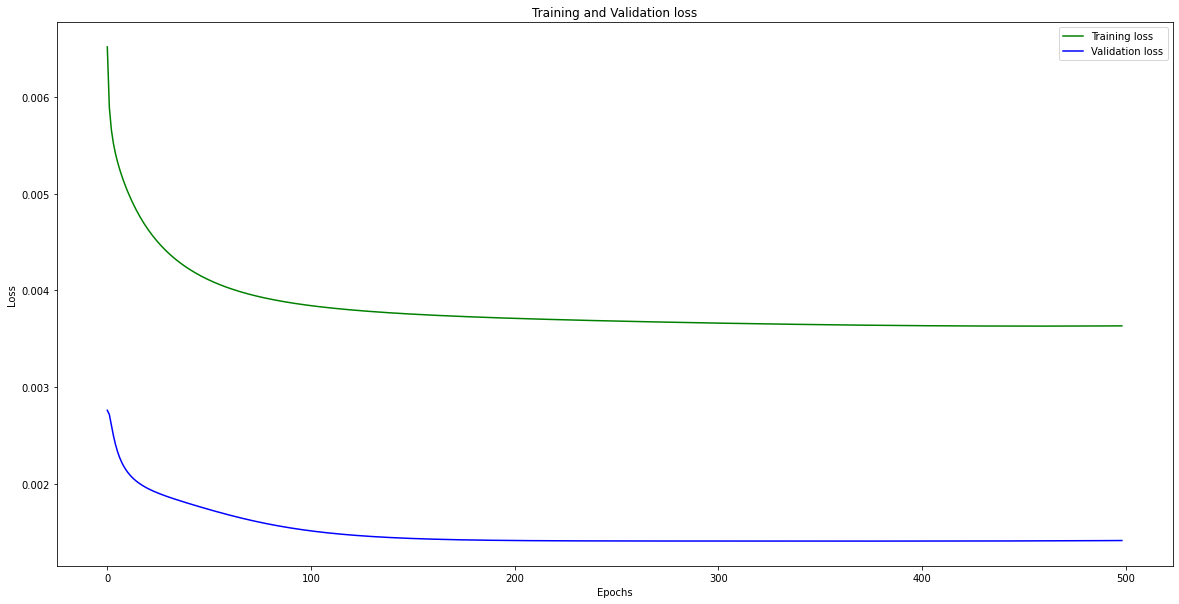

In [14]:
fro = 1  # evitar problemas de escala/avoid autoscale issues
plt.figure(figsize=(20,10))
plt.plot(history.history['loss'][fro:], 'g', label='Training loss')
plt.plot(history.history['val_loss'][fro:], 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### Probar la RNA
#### Test the ANN

In [15]:
loss_error = ann.evaluate(test_data, test_targets)
print(f"Test error: {loss_error}")

19/19 [==============================] - 0s 1ms/step - loss: 0.0018
Test error: 0.001785634784027934


#### Despliegue gráfico del rendimiento de la RNA entrenada
#### Graphically display the performance of the trained ANN

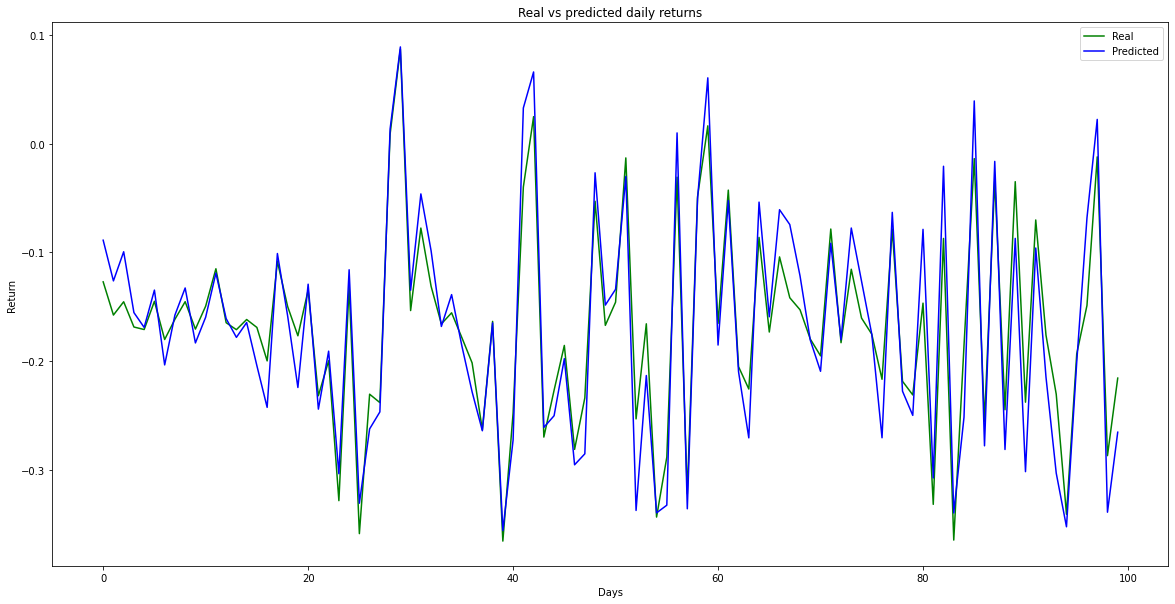

In [16]:
y_pred = ann.predict(test_data[:100])
plt.figure(figsize=(20,10))
plt.plot(test_targets[:100], 'g', label='Real')
plt.plot(y_pred, 'b', label='Predicted')
plt.title('Real vs predicted daily returns')
plt.xlabel('Days')
plt.ylabel('Return')
plt.legend()
plt.show()